In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import os
import scipy.sparse as sparse
import pickle

from itertools import chain
from pathlib import *
from math import ceil
from sqlalchemy import create_engine

from helper import *
from tree_weight import *
from time import time
from main import make_graph_from_tree
from multiprocessing import *

from typing import List
%matplotlib inline

In [135]:
image_folder = 'graphs/'
tree = 'benchmark_models/trucking/trees/04.sqlite'
info_df = to_df(tree, 'info').set_index('NodeID')
nodes_df = to_df(tree, 'nodes').set_index('NodeID')
map_dict = {}

if 'SubtreeSize' not in nodes_df:
    calculate_subtree_size(nodes_df)
    to_sqlite(nodes_df, tree)

valid_df = nodes_df[nodes_df['Status'] != 3]

def get_split_var(row, mappings=None):
    node_idx = row.name
    par_idx = valid_df.loc[node_idx, 'ParentID']
    if par_idx == - 1:
        return None
    cands, _, par_domain, children_domain = find_split_variable(par_idx, valid_df, info_df, mappings)
    return cands[0] if len(cands) == 1 else None

def get_parent_column(column: str, df: pd.DataFrame) -> pd.Series:
    has_root = 1 if 0 == df.index[0] else 0
    j = df.iloc[has_root:, :].reset_index().set_index('ParentID')[['NodeID', column]]
    j.loc[:, column] = df.loc[df.iloc[has_root:, :]['ParentID'], column]    
    return j.reset_index().set_index('NodeID')[column]
    
valid_df.loc[:, 'SplitVariable'] = valid_df.apply(get_split_var, axis=1, mappings=map_dict)
valid_df.loc[:, 'SubtreeSizeWeight'] = valid_df['SubtreeSize'] / get_parent_column('SubtreeSize', valid_df)
valid_df.loc[:, 'SearchSpaceWeight'] = valid_df['SearchSpaceNodeWeight'] / get_parent_column('SearchSpaceNodeWeight', valid_df)

In [136]:
nodes_df.shape

(45093, 10)

In [16]:
nodes_df.reset_index()[['ParentID', 'NodeID']]

,ParentID,NodeID
0,-1,0
1,0,1
2,0,2
3,1,3
4,1,4
...,...,...
776,772,776
777,775,777
778,775,778
779,776,779


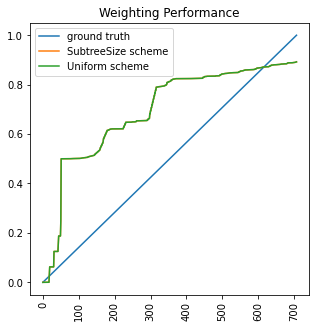

In [13]:
dfs_ordering = nodes_df[nodes_df['DFSOrdering'] != -1]\
                       ['DFSOrdering'].sort_values().index.to_list()
cum_weight = get_cum_weight(nodes_df, 'NodeWeight', dfs_ordering)
uniform_cum = get_cum_weight(nodes_df, 'SearchSpaceNodeWeight', dfs_ordering)
fig, ax = plot_goodness({'SubtreeSize': cum_weight, 'Uniform': uniform_cum})

In [88]:
def make_weight_parallel(j: int, use_parallel: bool=False):
    """
    Use a global variable to store weights generated by this function in a sparse matrix
    """
    global parallel_matrix, wa_state
    try:
        assert parallel_matrix is not None
        assert wa_state is not None
        
        valid_df = wa_state['valid_df']
        ws = wa_state['ws']
        weight_scheme = wa_state['weight_scheme']
        weight_colname = wa_state['weight_colname']

    except NameError:
        raise ValueError("Cannot run parallel weights creation method as no global storage for them exist!")
    except KeyError:
        raise ValueError("Weight assignment state not populated for parallel")
        
    par_weight = valid_df.loc[j, weight_colname]
    children = valid_df[valid_df['ParentID'].isin([j])]

    if children.shape[0] == 0:
        return

    weights = ws.get_weight(j, valid_df)
    # print(f"At node {j}, weights retrieved are {list(weights)}")
    assert len(weights) == children.shape[0]

    # store retrieved weights
    for i in range(len(children.index)):
        child_id = children.index[i]
        parallel_matrix['data'][child_id] = weights[i]
        parallel_matrix['row'][child_id] = j
    
    
        
def assign_weight(nodes_df: pd.DataFrame, weight_scheme: str, 
        weight_colname: str='NodeWeight',
        assign_in_dfs_order: bool=True,
        use_parallel: bool=False,
        **kwargs) -> None:
    """
    Assigns weight = 1 to root and propogates that weight down using a weighting scheme.
    Nodes which are backjumped over and pruned are ignored.
    
    Parameter:
        - nodes_df: dataframe of nodes, indexed by nodes_id
        - weight_scheme: name of function defined in WeightScheme class
        - kwargs: keyword arguments required for the weight scheme
    """
    
    nodes_df[weight_colname] = 0
    invalid_status = [3] # pruned nodes that are jumped over without being considered
    valid_df = pd.DataFrame.copy(nodes_df[~nodes_df['Status'].isin(invalid_status)])
    valid_df.loc[0, weight_colname] = 1 # root node has weight 1
    ws = make_weight_scheme(weight_scheme, assign_in_dfs_order=assign_in_dfs_order, **kwargs)

    if assign_in_dfs_order:
        assert 'DFSOrdering' in valid_df.columns
        index_lst = valid_df[valid_df['NKids'] > 0].sort_values('DFSOrdering').index
    else:
        index_lst = valid_df[valid_df['NKids'] > 0].index
    
    # propogate weights down
    if not use_parallel:
        for j in index_lst:
            par_weight = valid_df.loc[j, weight_colname]
            children = valid_df[valid_df['ParentID'].isin([j])]

            if children.shape[0] == 0:
                return

            weights = ws.get_weight(j, valid_df)
            # print(f"At node {j}, weights retrieved are {list(weights)}")
            assert len(weights) == children.shape[0]

            valid_df.loc[children.index, weight_colname] = par_weight * np.array(weights) 
            if weight_scheme in SUM_TO_1: # schemes requiring sum to 1
                assert abs(valid_df.loc[valid_df['ParentID'] == j, weight_colname].sum() - par_weight) < EPSILON
    
    else:
        # do the same things as above but stores weights in a global state array instead
        global parallel_matrix # declare variable in global scope
        parallel_matrix = {} # reset global state for new run
        parallel_matrix['data'] = Array('d', nodes_df.shape[0])
        parallel_matrix['row'] = Array('i', nodes_df.shape[0])
        
        global wa_state # state for weight assignment
        wa_state = {} # reset state
        wa_state['valid_df'] = valid_df
        wa_state['ws'] = ws
        wa_state['weight_colname'] = weight_colname
        wa_state['weight_scheme'] = weight_scheme

        try:
            pool = Pool(processes=os.cpu_count())
            pool.map(make_weight_parallel, index_lst)
        finally:
            pool.close()
            
        weights = sparse.csr_matrix((parallel_matrix['data'], (parallel_matrix['row'], range(nodes_df.shape[0]))), shape=(nodes_df.shape[0], nodes_df.shape[0]))
        running = weights
        
        while np.any((running[0] > 0).data):
            temp = running[0].tocoo()
            col = temp.col[temp.data > 0]
            valid_df.loc[col, weight_colname] = temp.data[temp.data > 0]
            running = running * weights
        
        del parallel_matrix
        del wa_state # free up memory
        
    if weight_scheme in SUM_TO_1: # schemes requiring sum to 1
        assert abs(valid_df.loc[valid_df['Status'].isin({0, 1, 3}), weight_colname].sum() - 1) < EPSILON

    # assign valid back to nodes, default invalid status nodes' weights to 0
    # this preserves the postconditions, as sum of children is unchanged
    nodes_df.loc[valid_df.index, weight_colname] = valid_df[weight_colname]
    nodes_df[weight_colname].fillna(0, inplace=True)

In [148]:
%%time
assign_weight(nodes_df, 'searchSpace_scheme', 'NodeWeightTest', use_parallel=True, info_df=info_df)

CPU times: user 829 ms, sys: 60.1 ms, total: 890 ms
Wall time: 47.3 s


Assign weight on trucking 04 with 45100 nodes and search Space scheme:
    - without parallel: 1min 23s ± 1.56 s per loop (mean ± std. dev. of 7 runs, 1 loop each) 
    - with parallel: 54.2 s ± 11.1 s per loop (mean ± std. dev. of 7 runs, 1 loop each)

    
Issue:
seemes parallel is not getting everything correct?
Maybe since with parallel the dict used by ws is not stable

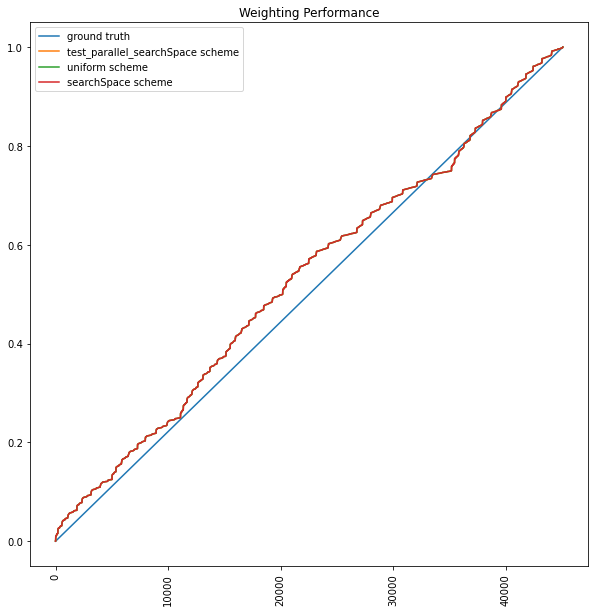

In [147]:
dfs_ordering = nodes_df[nodes_df['Status'] != 3].reset_index().sort_values('DFSOrdering')['NodeID']

cum_sums = {}
cum_sums['test_parallel_searchSpace'] = get_cum_weight(nodes_df, 'NodeWeightTest', dfs_ordering)
cum_sums['uniform'] = get_cum_weight(nodes_df, 'UniformNodeWeight', dfs_ordering)
cum_sums['searchSpace'] = get_cum_weight(nodes_df, 'SearchSpaceNodeWeight', dfs_ordering)

fig, ax = plot_goodness(cum_sums, figsize=(10, 10))

In [50]:
# see if subtree sizes follow the same characteristic

def fit_characteristic(row, nodes_df=None):
    node_id = row.name
    truth = nodes_df[nodes_df['ParentID'] == node_id]['SubtreeSize'].values
    a_s = [truth[i] / truth[i - 1] for i in range(1, len(truth))]
    return np.mean(a_s) if len(a_s) > 0 else 0

# for each parent node and the corresponding children
weights = valid_df[valid_df['Status'] == 2].apply(fit_characteristic, nodes_df=valid_df, axis=1)
# weighgs = pd.Series(weights)

# valid_df[valid_df['Status'] == 2].reset_index()['NodeID'].apply(fit_characteristic, nodes_df=valid_df)

In [52]:
weights[weights > 50]

NodeID
90     407.0
92     127.0
218    125.0
220    123.0
222    121.0
224    119.0
228     73.0
300     71.0
302     69.0
304     67.0
374    405.0
376    403.0
378    401.0
380    399.0
382    397.0
384    395.0
386    393.0
388    391.0
402     72.2
433     85.0
436     83.0
dtype: float64

In [53]:
nodes_df[nodes_df['ParentID'] == 374]

,ParentID,Alternative,NKids,Status,Label,DFSOrdering,DomainNodeWeight,NodeWeight,SearchSpaceNodeWeight,SubtreeSize,UniformNodeWeight
NodeID,,,,,,,,,,,
375,374,0,0,1,X_INTRODUCED_17_ = 28,302,1.982886e-34,0.0625,0.011905,1,0.0625
376,374,1,2,2,X_INTRODUCED_17_ != 28,303,4.212590e-20,0.0625,0.226190,405,0.0625


nodes_df['
- total time: 20min
- make_dfs_ordering: 3m30s
- load info_df: 365ms
- load nodes_df: 404ms
- copy nodes_df: 7.96ms
- assign weights to nodes_df: 7min30s
- assign weights to test_df: 12min26s
- get_cum_weights for nodes_df: 156ms
- get_cum_weights for test_df: 125ms


f(par_idx) -> list[nkids weights]

Simple solution:
    f(par_idx) = 
    x = np.array([(weight**i) for i in range(nodes_df.loc[par_idx, 'NKids'])])
    # normalize x so it adds to 1
    x = x / x.sum()

ON.RETURN.TO.HIGHER LEVEL
    seen_idx.append(node_id)
    new_weight = fit_characteristic_weight(seen_idx) # find weight that best fit the known curve
    weight = alpha * weight + (1  - alpha) * new_weight # exponential decay
    
    

INITIALIZE WEIGHT
    weight = 1 # no drop of subtree size
    

def fit_characteristic_weight(seen_idx, nodes_df):
    
    truth = nodes_df.loc[seen_idx, 'SubtreeSize'].values
    a_s = [truth[i] / truth[i - 1] for i in range(1, len(truth))]
    return np.mean(a_s)
    
given data subtree_s(0..k):
a1 = subtree_s(1) / subtree_s(0)
a2 = subtree_s(2) / subtree_s(1)
a3 = ...

find w that minimizes 1/2(a1..k - w)^2 -> w = mean(a1, a2, a3, a4)


1, 1/w, 1/w^2, 1/w^3, 1/w^4, ... 1/w^n -> normalized -> 1/w^k * 

sum(1, 1/w, 1/w^2, ... 1/w^n) = S
wS = w + 1 + 1/w + .. + 1/w^(n - 1) = w + S - 1/w^n => S(w - 1) = w - 1/w^n = (w - 1/w^n) / (w - 1)

In [ ]:
nodes_df['No